## **1. Data Preparation** 
#### Importing Libraries


In [13]:
import os
import numpy as np
import gzip
import urllib.request
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import random
from torch.utils.data import DataLoader, ConcatDataset, Subset,TensorDataset, Dataset
from torchvision.transforms import functional as F
import torch.nn.functional as F
from torch.utils.data import random_split

### **1.1 Data Loading and Preprocessing**

In [8]:
urls = {
    "train_images": "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "test_images": "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz"
}

NOTE: Official URL dataset extract fails - http://yann.lecun.com/exdb/mnist/

In [7]:
# Function to download and extract files
def download_and_extract(url, path, is_label=False):
    if not os.path.exists(path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"{path} already exists, skipping download.")

    offset = 8 if is_label else 16 # Handle labels separately as their header is 8 bytes instead of 16
    with gzip.open(path, 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=offset)

In [9]:
def load_mnist_data():
    os.makedirs('./data', exist_ok=True)

    train_images = download_and_extract(urls['train_images'], './data/train-images.gz')
    train_labels = download_and_extract(urls['train_labels'], './data/train-labels.gz', is_label=True)
    test_images = download_and_extract(urls['test_images'], './data/test-images.gz')
    test_labels = download_and_extract(urls['test_labels'], './data/test-labels.gz', is_label=True)

    # Reshape and normalize the images
    train_images = train_images.reshape(-1, 28, 28) / 255.0
    test_images = test_images.reshape(-1, 28, 28) / 255.0

    # Combine train and test datasets for custom split
    images = np.concatenate((train_images, test_images), axis=0)
    labels = np.concatenate((train_labels, test_labels), axis=0)

    return images, labels

images, labels = load_mnist_data()
print("MNIST data downloaded and loaded.")

Downloaded ./data/train-images.gz
Downloaded ./data/train-labels.gz
Downloaded ./data/test-images.gz
Downloaded ./data/test-labels.gz
MNIST data downloaded and loaded.


In [10]:
def split_data(images, labels):
    total_size = len(images)

    # Calculate sizes for each split
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    # Create splits
    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

# Split into training, validation, and testing sets (60%, 20%, 20%)
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_data(images, labels)

# Output the sizes of each dataset
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 42000
Validation set size: 14000
Test set size: 14000


Example image shape: (28, 28)


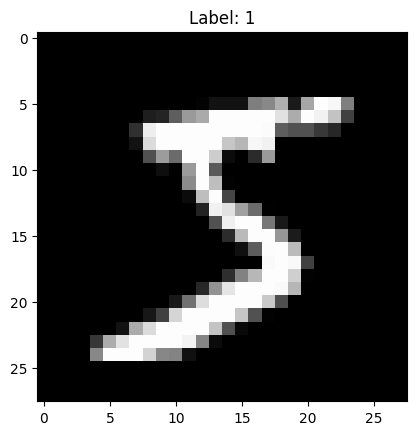

In [11]:
# Show the shape of an example image
print(f"Example image shape: {train_images[0].shape}")

# Display the first image in the training set (requires matplotlib)
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

In [14]:
# Create custom Dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension (1 for grayscale)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [15]:
# Create datasets
train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(val_images, val_labels)
test_dataset = MNISTDataset(test_images, test_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example of accessing a batch from the DataLoader
train_iter = iter(train_loader)
images, labels = next(train_iter)
print(f"Batch image shape: {images.shape}, Batch label shape: {labels.shape}")

Batch image shape: torch.Size([64, 1, 28, 28]), Batch label shape: torch.Size([64])


### **1.2 Data Analysis and Visulaization**

#### 1.2.1 Sample Images- Visualization

In [263]:
# plot samples with labels
def plot_samples(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

class_names = [str(i) for i in range(10)]
N = 1000  # Num of images for correlation

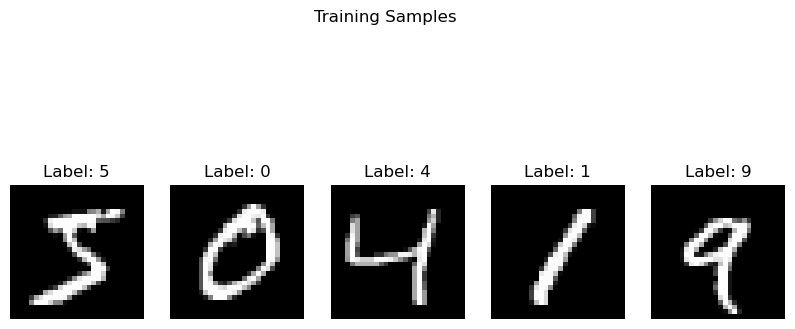

In [264]:
# Convert the first N images to a numpy array
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
plot_samples(train_dataset.data.numpy()[:5], train_labels.numpy()[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

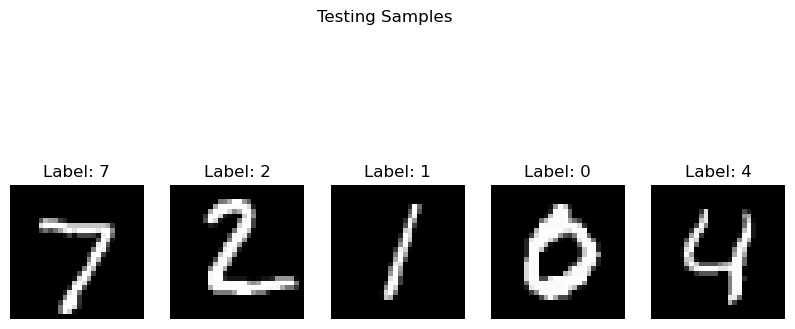

In [265]:
# Plot testing samples
test_images = torch.stack([test_dataset[i][0] for i in range(5)])
test_labels = torch.tensor([test_dataset[i][1] for i in range(5)])
plot_samples(test_images.numpy(), test_labels.numpy(), class_names, num_samples=5)
plt.suptitle('Testing Samples')
plt.show()#plot

#### 1.2.2 Mean and Standard Deviation

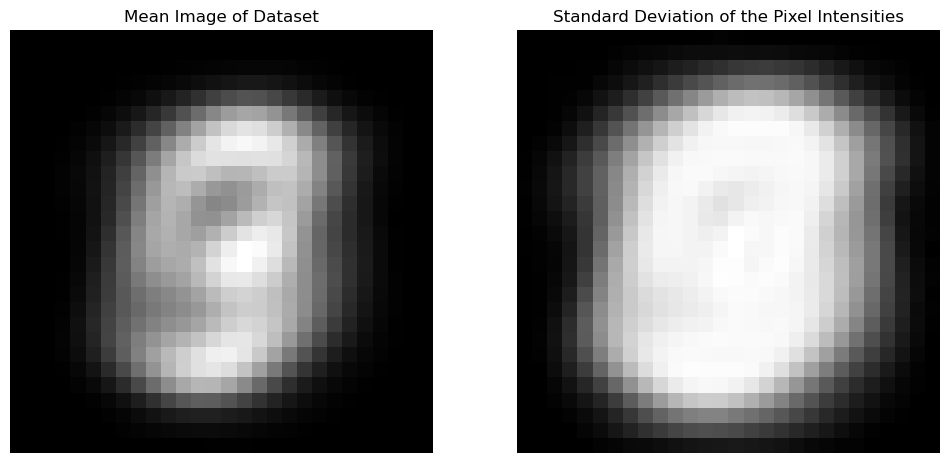

In [266]:
mean_image = torch.mean(train_dataset.data.float(), dim=0) # Mean of dataset
std_image = torch.std(train_dataset.data.float(), dim=0)  # Standard deviation of dataset

plt.figure(figsize=(12, 6))
# Mean image
plt.subplot(1, 2, 1)
plt.imshow(mean_image, cmap='gray')
plt.title("Mean Image of Dataset")
plt.axis('off')

# Standard deviation image
plt.subplot(1, 2, 2)
plt.imshow(std_image, cmap='gray')
plt.title("Standard Deviation of the Pixel Intensities")
plt.axis('off')

plt.show()

#### 1.2.3 Correlation Matrix of MNIST pixel values

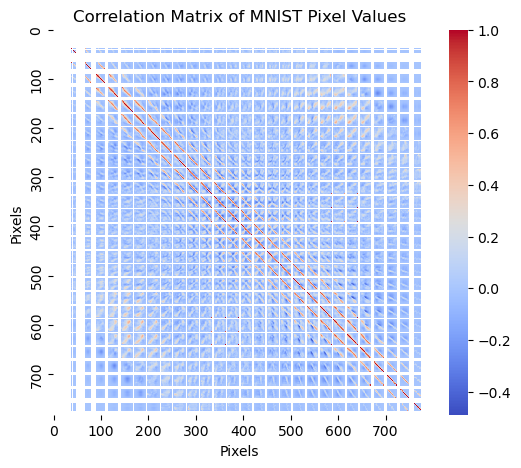

In [267]:
import warnings

train_images = torch.stack([train_dataset[i][0] for i in range(N)])
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
train_images = train_images.view(N, -1).numpy()

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_images.T)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, xticklabels=100, yticklabels=100)
plt.title('Correlation Matrix of MNIST Pixel Values')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

#### 1.2.4 Distribution of Digits

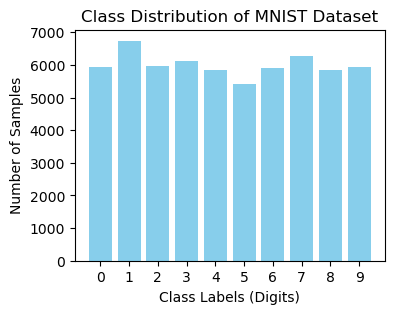

In [268]:
labels = train_dataset.targets

unique, counts = np.unique(labels.numpy(), return_counts=True)

# Create a bar plot for class distribution
plt.figure(figsize=(4, 3))
plt.bar(unique, counts, color='skyblue')
plt.title('Class Distribution of MNIST Dataset')
plt.xlabel('Class Labels (Digits)')
plt.ylabel('Number of Samples')
plt.xticks(unique)  # Set x-axis ticks to be the class labels
plt.show()

In [269]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")

Total Training Samples: 60000
Total Testing Samples: 10000
Image Shape: torch.Size([1, 28, 28])


#### 1.2.5 Principal Component Analysis (PCA) on dataset

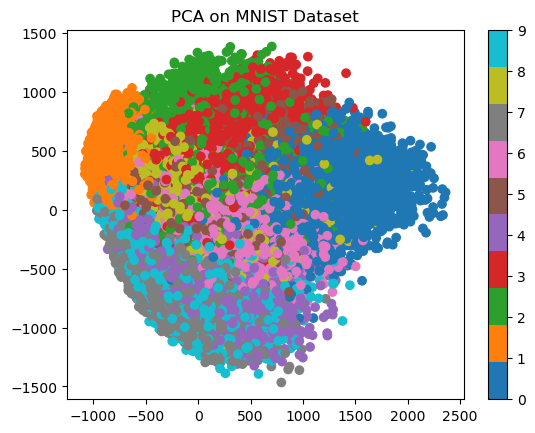

In [270]:
# Flatten the images for PCA
data = train_dataset.data.view(-1, 28*28).numpy()
labels = train_dataset.targets.numpy()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('PCA on MNIST Dataset')
plt.show()

#### 1.1.1 Data Augmentation
#### 1.3 Rotating selected images in the dataset to increase the diversity in data

#### Procedeure 

Define the transformations to rotate the images to left and right by 15 and 5 degrees.
A function is defined to rotate and replace since the same code can be reused for training and testing.
The daaset, no of classes and the portion of data in which we are going to select are used as inputs to the function.
Inside the function, create a dictionary to store the indices of data points belonging to each class.
format of the dictionary will be like {0 :[],1:[]}.
since we are going to rotate to left by 15 and 5 and rotatw tight to by 15 and 5 divide the dataset to 4 to avoid any duplicates





In [271]:
random.seed(42) # create a fix random value

# Define transformations: rotations by different angles
rotate_r15 = transforms.RandomRotation(degrees=(-15, -15))
rotate_r5 = transforms.RandomRotation(degrees=(-5, -5))
rotate_l15 = transforms.RandomRotation(degrees=(5, 5))
rotate_l5 = transforms.RandomRotation(degrees=(15, 15))

to_tensor_transform = transforms.ToTensor()

# Function to divide, rotate, and replace 20% of images from each class
def rotate_and_replace(dataset, class_count, selected_portion):
    class_indices = {}
    for i in range(class_count):
        class_indices[i] = []

    for img_index in range(len(dataset)):
        original_image, label = dataset[img_index]
        class_indices[label].append(img_index)


    # For each class, divide 20% of images into 4 parts and apply rotations
    for class_label, indices in class_indices.items():
        num_to_rotate = int(len(indices) * selected_portion)
        selected_indices = random.sample(indices, num_to_rotate)

        quarter_size = num_to_rotate // 4

        for index_r_15 in selected_indices[:quarter_size]:
            original_image, label = dataset[index_r_15]
            rotated_image = rotate_r15(original_image)
            dataset.data[index_r_15] = (rotated_image * 255).byte()

        for index_r_5 in selected_indices[quarter_size:2 * quarter_size]:
            original_image, label = dataset[index_r_5]
            rotated_image = rotate_r5(original_image)
            dataset.data[index_r_5] = (rotated_image * 255).byte()

        for index_l_15 in selected_indices[2 * quarter_size:3 * quarter_size]:
            original_image, label = dataset[index_l_15]
            rotated_image = rotate_l15(original_image)
            dataset.data[index_l_15] = (rotated_image * 255).byte()

        for index_l_5 in selected_indices[3 * quarter_size:]:
            original_image, label = dataset[index_l_15]
            rotated_image = rotate_l5(original_image)
            dataset.data[index_l_15] = (rotated_image * 255).byte()

    return dataset



#### 1.3.1 Apply for the training set

In [272]:
train_dataset = rotate_and_replace(train_dataset, 10, 0.2)

#### 1.3.2 Test output after rotating

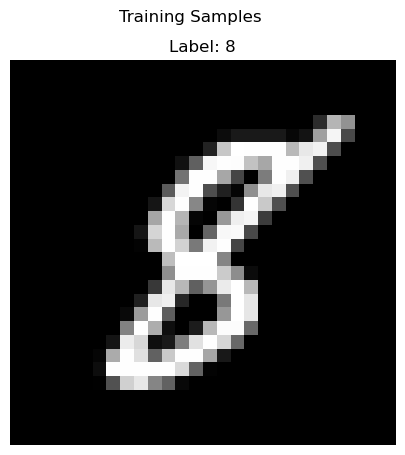

In [273]:
train_images = torch.stack([train_dataset[202][0]])
train_labels = torch.tensor([train_dataset[202][1]])
plot_samples(train_images.numpy(), train_labels.numpy(), class_names, num_samples=1)
plt.suptitle('Training Samples')
plt.show()#plot

#### 1.4 Flip sample of data

In [274]:
#  Get 20% of the training dataset
fraction = 0.2
num_samples = int(fraction * len(train_dataset))
indices = list(range(len(train_dataset)))
random.shuffle(indices)
subset_indices = indices[:num_samples]

# Get subset of the training
selected_subset = Subset(train_dataset, subset_indices)

# Transform for flipping
transform = transforms.RandomHorizontalFlip(p=1.0)  #

# Apply flipping to the subset
flipped_images = []
flipped_labels = []

for i in range(len(selected_subset)):
    image, label = selected_subset[i]

    #if the image is a tensor apply the transform
    if isinstance(image, torch.Tensor):
        flipped_image = transform(image)
    else:
        flipped_image = transform(transforms.ToPILImage()(image))  # Convert to PIL if not a tensor

    flipped_images.append(flipped_image)
    flipped_labels.append(label)

# Convert lists to tensors
flipped_images_tensor = torch.stack(flipped_images)
flipped_labels_tensor = torch.tensor(flipped_labels)

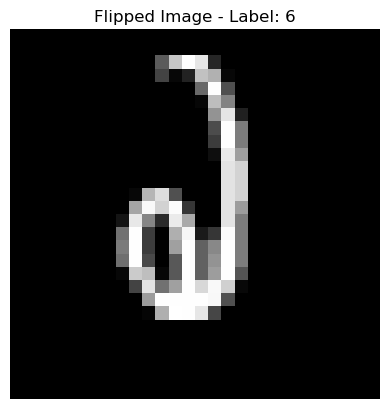

In [275]:
# Display a sample flipped image
def show_image(tensor_image):
    # Unnormalize the image
    unnormalized_image = tensor_image * 0.5 + 0.5
    # Convert the tensor back to a PIL image
    pil_image = transforms.ToPILImage()(unnormalized_image)
    return pil_image

sample_index = 2

# Get the flipped image and its label
flipped_sample_image = flipped_images[sample_index]
flipped_sample_label = flipped_labels[sample_index]

# Show the flipped image
plt.imshow(show_image(flipped_sample_image), cmap="gray")
plt.title(f"Flipped Image - Label: {flipped_sample_label}")
plt.axis('off')
plt.show()

#### 1.4.1 Update Training data

In [276]:
for i, idx in enumerate(subset_indices):
    train_dataset.data[idx] = (flipped_images[i] * 255).byte()
    train_dataset.targets[idx] = flipped_labels[i]

# Shuffle dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Print the new size
print("Size of the training dataset:", len(train_dataset))

Size of the training dataset: 60000


#### 1.5 Sharpen images


In [277]:
# Get 20% of the training dataset
fraction = 0.2
num_samples = int(fraction * len(train_dataset))
indices = list(range(len(train_dataset)))
random.shuffle(indices)
subset_indices = indices[:num_samples]

# Create a subset
selected_subset = Subset(train_dataset, subset_indices)

# Func sharpening using a kernel
def sharpen_image(tensor_image):
    # Set kernel
    sharpen_kernel = torch.tensor([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Apply filter
    tensor_image = tensor_image.unsqueeze(0).float()  # Convert to float and add batch dimension
    sharpened_image = F.conv2d(tensor_image, sharpen_kernel, padding=1)
    # Clip values to [0, 1]
    sharpened_image = torch.clamp(sharpened_image, 0, 1).squeeze(0)  # Remove batch dimension
    return sharpened_image

# Apply sharpening to the selected subset
sharpened_images = [sharpen_image(selected_subset[i][0]) for i in range(len(selected_subset))]
sharpened_labels = [selected_subset[i][1] for i in range(len(selected_subset))]

In [278]:
# Update the dataset
all_images = train_dataset.data.clone().float() / 255.0  # Normalize to [0, 1]
all_labels = train_dataset.targets.clone()

# Replace the selected portion of the dataset with the sharpened images
for i, idx in enumerate(subset_indices):
    all_images[idx] = sharpened_images[i]
    all_labels[idx] = sharpened_labels[i]

# Convert the modified images back to the original format
all_images = (all_images * 255).byte()

# Update the original dataset attributes
train_dataset.data = all_images
train_dataset.targets = all_labels

# Shuffle the updated dataset using DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Print the size of the training dataset (it should remain unchanged)
print("Size of the training dataset:", len(train_dataset))

Size of the training dataset: 60000


#### 1.5.1. Display shapen image

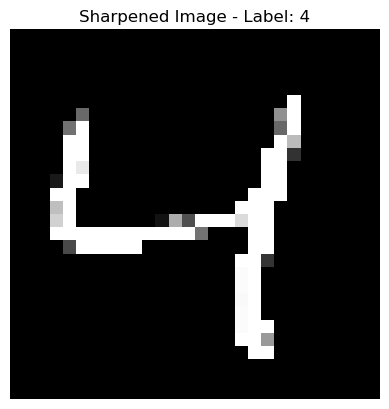

In [279]:
# Display sharpened image and its label
def show_sharpened_sample(dataset, sample_index):
    sharpened_sample_image = dataset[sample_index][0]  # Get the sharpened image tensor
    sharpened_sample_label = dataset[sample_index][1]  # Get the corresponding label

    # Convert tensor image to PIL
    def show_image(tensor_image):
        # Unnormalize the image
        unnormalized_image = tensor_image * 0.5 + 0.5
        # Convert the tensor back to a PIL image
        pil_image = transforms.ToPILImage()(unnormalized_image)
        return pil_image

    # Show the sharpened image
    plt.imshow(show_image(sharpened_sample_image), cmap="gray")
    plt.title(f"Sharpened Image - Label: {sharpened_sample_label}")
    plt.axis('off')
    plt.show()

# Display a sample sharpened image and its label
sample_index = 2  # Change this index to view different samples
show_sharpened_sample(train_dataset, sample_index)

#### 1.6 Split data

In [281]:
# Define the split ratio
val_split = 0.2  # 20% for validation
train_len = int((1 - val_split) * len(train_dataset))  # 80% for training
val_len = len(train_dataset) - train_len  # Remaining 20% for validation

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])
# Print size
print("Size of training dataset:", len(train_dataset))
print("Size of validating dataset:", len(val_dataset))

Size of training dataset: 38400
Size of validating dataset: 9600
